# ML 2025 Spring. Unsupervised

## Контакты участника

Если у вас возникли вопросы по этому проекту или вы хотите обсудить сотрудничество, свяжитесь со мной:

- Email: gerceg0808@yandex.ru   
- Tg: [@GercKLIM](https://t.me/GercKLIM)
- GitHub: [@GercKLIM](https://github.com/GercKLIM) 

## Описание
Вам предоставлен набор данных -- некоторых вещественно значных признаков. Вам нужно проставить метки классов, другими словами кластеризовать данные.

Метрика оценки качества -- Adjusted Rand Score

Данные -- sparse матрица размера (21000, 3049).

## Оценка:

1. Ниже simple порога — **0 баллов**.
   - Если ваш итоговый скор ниже simple порога, вы получите 0 баллов.

2. Выше simple порога:
   - Баллы распределяются по формуле:
     \[
     grade = 5 + 5 \cdot \frac{your\_score - simple\_score}{best\_score - simple\_score}
     \]
   - То есть:
     - Если ваш итоговый скор близок к simple порогу, то вы получите около **5 баллов**.
     - При этом, если ваше решение близко к лучшему решению на лидерборде, то вы получите близкое к максимальному баллу (**10**).
   

### Hard Deadline: **4 мая 23:55**


## 1. Загрузка и первичный анализ данных

На этом этапе:
- Загружается разреженная матрица из файла `data/train.npz`.
- Выполняется базовый анализ данных:
  - Выводится размер матрицы.
  - Тип данных.
  - Количество ненулевых элементов.
  - Степень разреженности матрицы.
  - Среднее значение, стандартное отклонение.
  - Минимальное и максимальное значение признаков.

После анализа данные преобразуются из спарсного формата в плотный (`dense`), чтобы была возможность применять различные методы предобработки и кластеризации.

Также выполняется **стандартизация** с использованием одного из скалеров из `sklearn.preprocessing`.

Здесь производится выбор скалера. 

Этот этап необходим для подготовки данных к дальнейшей визуализации и кластеризации.

In [60]:
from scipy.sparse import load_npz
import numpy as np
import pandas as pd

# Загрузка датасета
train = load_npz("data/train.npz")

In [61]:
# Вывод различных агрегаций
print("Shape of the matrix:", train.shape)
print("Data type:", train.dtype)
print("Number of non-zero elements:", train.nnz)
print("Sparsity ratio:", train.nnz / (train.shape[0] * train.shape[1]))
print()

# Преобразуем спарс-матрицу в dense формат для анализа 
dense_train = train.toarray()

# Проверяем среднее значение и стандартное отклонение
print("Mean:", dense_train.mean())
print("Standard deviation:", dense_train.std())

# Проверяем диапазон значений
print("Min value:", dense_train.min())
print("Max value:", dense_train.max())

Shape of the matrix: (21000, 3049)
Data type: float64
Number of non-zero elements: 11704521
Sparsity ratio: 0.18280030923487794

Mean: 32.13573808896806
Standard deviation: 1763.0738579489714
Min value: -253.840036242498
Max value: 100000.0


In [62]:
# Посмотрим на этого многомерного зверя
print(dense_train[:5])  # Первые 5 строк

#dense_train

[[0.         0.         0.         ... 9.159356   0.         0.        ]
 [0.         0.         0.         ... 4.43292687 0.         0.        ]
 [0.         0.         1.         ... 6.10839882 0.         0.        ]
 [0.         0.         0.         ... 2.20168328 0.         0.        ]
 [0.         0.98440065 0.         ... 9.80793923 0.         0.        ]]


In [63]:
# Кол-во нулей? много
print("Number of zero elements:", (dense_train == 0).sum())

Number of zero elements: 52324479


In [64]:
from scipy.sparse import csr_matrix

# Пример: train — это sparse matrix (csr_matrix)
train_sparse = csr_matrix(train)

# Суммируем по столбцам (axis=0), получаем индексы нулевых столбцов
zero_cols = (train_sparse.getnnz(axis=0) == 0)
num_zero_cols = zero_cols.sum()

# Считаем число нулевых строк
zero_rows_mask = (train_sparse.getnnz(axis=1) == 0)
num_zero_rows = zero_rows_mask.sum()

print(f"Число нулевых столбцов: {num_zero_cols}")
print(f"Число нулевых строк: {num_zero_rows}")

Число нулевых столбцов: 616
Число нулевых строк: 0


In [65]:
# Удалим нулевые столбцы?

# Приводим к формату CSR, если нужно
train_sparse = csr_matrix(train)

# Находим ненулевые столбцы
non_zero_cols_mask = (train_sparse.getnnz(axis=0) > 0)

# Фильтруем матрицу — оставляем только ненулевые столбцы
train_filtered = train_sparse[:, non_zero_cols_mask]

print("Форма до удаления нулевых столбцов:", train_sparse.shape)
print("Форма после удаления нулевых столбцов:", train_filtered.shape)

train = train_filtered

Форма до удаления нулевых столбцов: (21000, 3049)
Форма после удаления нулевых столбцов: (21000, 2433)


In [66]:
# Преобразуем в плотную матрицу 
X_dense = train.toarray()

# Стандартизация данных (!очень важно для (H)DBSCAN!)
from sklearn.preprocessing import StandardScaler, MinMaxScaler,MaxAbsScaler,RobustScaler, QuantileTransformer,PowerTransformer

# Выбор скалера
# scaler = StandardScaler() 
# scaler = MinMaxScaler() # Плохо
# scaler = MaxAbsScaler() # Плохо
# scaler = RobustScaler() 
# scaler = QuantileTransformer() # Плохо
 
scaler = PowerTransformer()  

# Применяем выбранный скалер
X_scaled = scaler.fit_transform(X_dense)

## 2. Визуализация данных с помощью t-SNE

На этом этапе:
- Используется **t-SNE (t-Distributed Stochastic Neighbor Embedding)** для снижения размерности данных до **2D**, чтобы можно было визуализировать их на плоскости.
- Результаты отображаются с помощью `matplotlib`, где каждая точка соответствует одному объекту из данных.

Эта визуализация поможет понять структуру данных и проверить, насколько хорошо они группируются перед применением методов кластеризации.

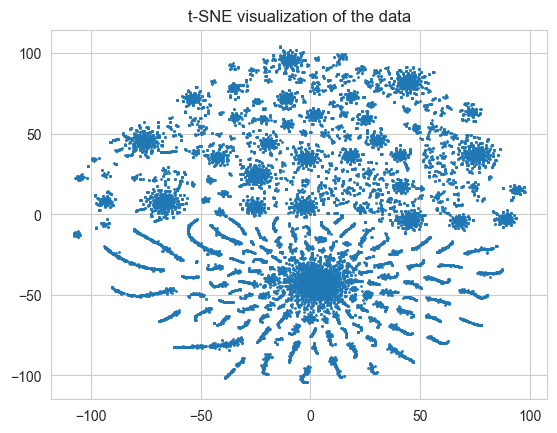

In [67]:
# Долго работает! - Посмотрели и запомнили 

from sklearn.manifold import TSNE

# Уменьшаем до 2D для визуализации
X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X_dense)

# Рисуем
import matplotlib.pyplot as plt
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=1)
plt.title("t-SNE visualization of the data")
plt.show()

## 3. Визуализация данных с помощью UMAP

На этом этапе:
- Применяется алгоритм **UMAP (Uniform Manifold Approximation and Projection)** — ещё один мощный метод снижения размерности, часто превосходящий t-SNE по скорости и сохранению глобальной структуры данных.
- Данные из плотного представления `X_dense` проецируются в двумерное пространство (`n_components=2`) с помощью UMAP.
- Результат отображается на графике с использованием `matplotlib`.


Эта визуализация поможет понять топологию данных и сравнить эффективность UMAP против t-SNE.

C:\WORK_DIRECTORY\PREP-to-JOB\Python-FW\Pandas-example\pythonProject\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


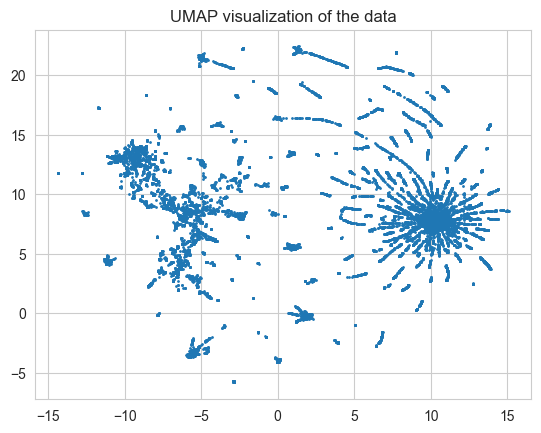

In [68]:
import umap

reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_dense)
plt.scatter(X_umap[:, 0], X_umap[:, 1], s=1)
plt.title("UMAP visualization of the data")
plt.show()

## 4. Анализ главных компонент (PCA)

На этом этапе:
- Применяется метод **Principal Component Analysis (PCA)** — классический подход к снижению размерности, основанный на поиске направлений максимальной дисперсии.
- Вычисляется **доля объяснённой дисперсии** для каждого компонента.
- Строится график **кумулятивной объяснённой дисперсии** в зависимости от количества компонент.


Этот анализ полезен при подготовке данных к дальнейшей кластеризации или снижению размерности с минимальными потерями информации.

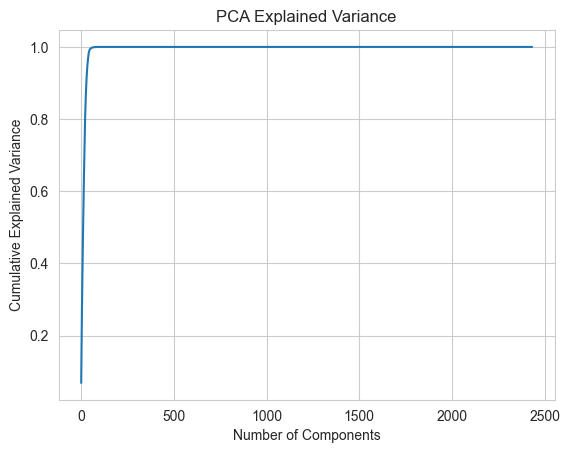

In [69]:
from sklearn.decomposition import PCA

pca = PCA().fit(X_dense)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

## 5. Кластеризация с помощью K-Means

На этом этапе:
- Применяется один из самых популярных алгоритмов кластеризации — **K-Means**, который разбивает данные на заданное количество кластеров (`n_clusters`).
- В данном случае мы выбираем `n_clusters`, основываясь на оценках из оценивающей системы и метриках, чтобы получить достаточно детализированное разделение данных.
- Модель обучается и сразу предсказывает метки кластеров для каждого объекта в датасете.

K-Means чувствителен к масштабу признаков, поэтому предыдущая стандартизация была обязательной.



In [70]:
# Опциональное меньшение размерности задачи
# import umap
# umap_model = umap.UMAP(n_components=20, random_state=42)
# X_umap = umap_model.fit_transform(X_scaled)

In [71]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 7, random_state=42)
labels = kmeans.fit_predict(X_scaled)  # Обучаем и предсказываем кластеры

## 6. Оценка качества кластеризации

После получения меток кластеров с помощью K-Means, важно оценить, насколько хорошо данные разделены на кластеры.

Для этого мы используем три популярные метрики:
- **Silhouette Score** — показывает, насколько объекты внутри кластера близки друг к другу по сравнению с другими кластерами. Значение близко к `1` говорит о хорошем разделении.
- **Calinski-Harabasz Index** — мера, основанная на соотношении межкластерной и внутрикластерной дисперсии. Чем выше значение — тем лучше.
- **Davies-Bouldin Score** — мера, характеризующая среднее «сходство» между кластерами. Чем ниже значение — тем лучше.

Ниже приведены значения метрик для текущего разбиения на кластеры.

In [72]:
# ДОЛГО (и не совсем показательно судя по всему)
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Вычисляем метрики качества кластеризации
print(f"Silhouette Score: {silhouette_score(X_scaled, labels):.4f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, labels):.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin_score(X_scaled, labels):.4f}")

Silhouette Score: -0.0041
Calinski-Harabasz Score: 30.47
Davies-Bouldin Score: 15.6735


## 7. Формирование файла для отправки (submission.csv)

После завершения кластеризации и анализа качества, формируем финальный файл `submission.csv`, который будет отправлен на платформу Kaggle.

Файл содержит две колонки:
- `ID` — индекс объекта из исходной выборки
- `TARGET` — предсказанная метка кластера для каждого объекта

Ниже представлен код для сохранения результата в CSV-файл.

In [73]:
import pandas as pd

submission = pd.DataFrame({
    "ID": range(len(labels)),
    "TARGET": labels
})

submission.to_csv("result/submission_submit_main_5.csv", index=False)
print("Cохранение прошло успешно!")

Cохранение прошло успешно!


## 8. Сравнение с эталонным решением (Adjusted Rand Score)

Основываясь на скоре предыдущего файла, отправленного в соревнование, мы можем оценить, насколько наше решение соответствует ему. Так мы исследуем изменение метрик в результатах в зависимости от скора на платформе Kaggle.

Для этого используется метрика:
- **Adjusted Rand Score (ARI)** — мера схожести между двумя разбиениями, не зависящая от обозначения кластеров. Значение:
  - `1.0` — идеальное совпадение
  - `0.0` — случайное разбиение
  - Может быть отрицательным, если совпадение хуже случайного


Ниже приведён код для загрузки истинных меток и вычисления Adjusted Rand Score.

In [74]:
true_labels = pd.read_csv("submission_submit_main_1.csv")["TARGET"].values
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Score vs Sample Submission: {ari:.4f}")

Adjusted Rand Score vs Sample Submission: 0.9230


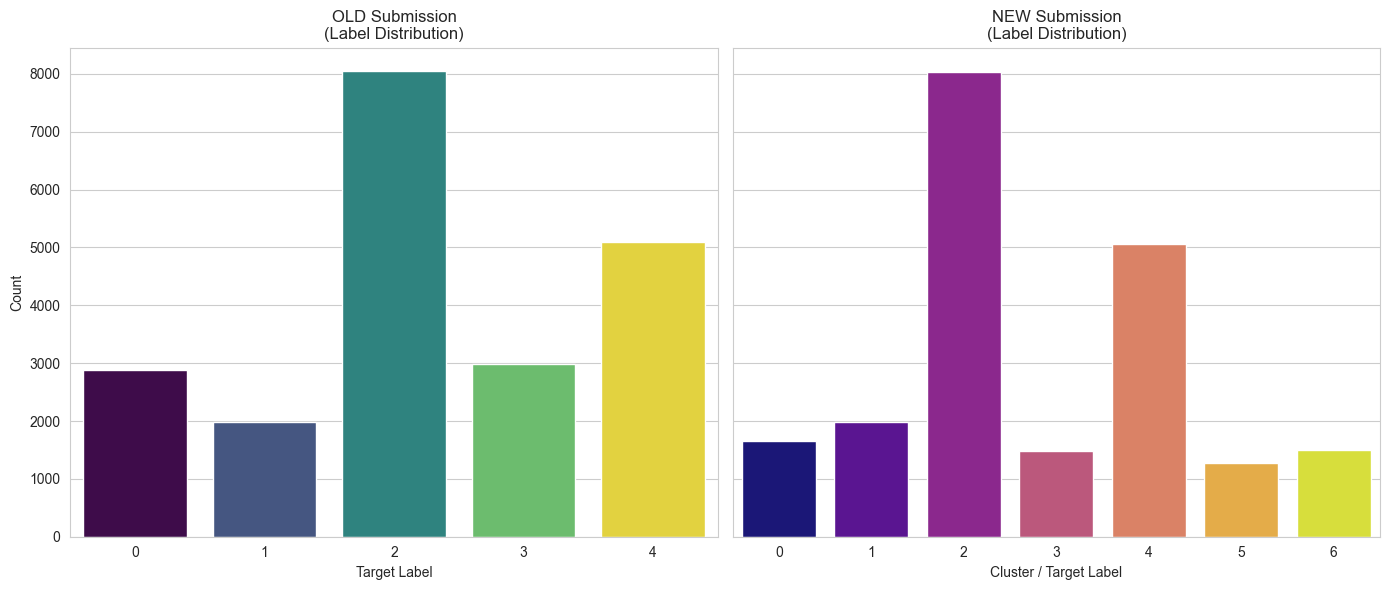


Adjusted Rand Score vs Sample Submission: 0.9230

Unique labels in sample submission: [2 4 0 3 1]
Label distribution in sample submission:
 TARGET
0    2888
1    1991
2    8049
3    2980
4    5092
Name: count, dtype: int64

Unique labels in predicted submission: [2 4 5 0 3 6 1]
Label distribution in predicted submission:
 TARGET
0    1657
1    1991
2    8033
3    1485
4    5058
5    1274
6    1502
Name: count, dtype: int64


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем пример подачи решения (sample submission)
submission_example = pd.read_csv("submission_submit_main_1.csv")

# Предсказанные метки
predicted_labels = labels

submission_predicted = pd.DataFrame({
    "ID": range(len(predicted_labels)),
    "TARGET": predicted_labels
})

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# График 1: Распределение в sample submission
sns.countplot(x="TARGET", data=submission_example, ax=axes[0], hue="TARGET", palette="viridis", legend=False)
axes[0].set_title("OLD Submission\n(Label Distribution)")
axes[0].set_xlabel("Target Label")
axes[0].set_ylabel("Count")

# График 2: Распределение в предсказаниях
sns.countplot(x="TARGET", data=submission_predicted, ax=axes[1], hue="TARGET", palette="plasma", legend=False)
axes[1].set_title("NEW Submission\n(Label Distribution)")
axes[1].set_xlabel("Cluster / Target Label")
axes[1].set_ylabel("Count")

plt.tight_layout()
plt.show()


print()
ari = adjusted_rand_score(true_labels, labels)
print(f"Adjusted Rand Score vs Sample Submission: {ari:.4f}")
print()
    
# Вывод уникальных меток и распределений
print("Unique labels in sample submission:", submission_example["TARGET"].unique())
print("Label distribution in sample submission:\n", submission_example["TARGET"].value_counts().sort_index())

print("\nUnique labels in predicted submission:", submission_predicted["TARGET"].unique())
print("Label distribution in predicted submission:\n", submission_predicted["TARGET"].value_counts().sort_index())

In [76]:
pd.read_csv("submission_submit_main_1.csv")["TARGET"].values

array([2, 4, 4, ..., 3, 4, 3])

# 9. Результаты в соревновании

## Модели 
Я пробовал различные модели, но по скору в каггле остановился на kmeans.

- UMAP + HDBSCAN: 0.01

- DEC: 0.01

- DBSCAN: 0.24

- AutoEncoders + Kmeans: 0.0

- Kmeans: 0.575
- 
## Лучшая модель - Kmeans
Kmeans:

- 4 clusters: 0.426
- 5 clusters: 0.575
- 6 clusters: 0.542
- 7 clusters: 0.563

-> Предполагаю, что кластеров чуть больше.

## Оценка в баллах :)


In [77]:
my_score = 0.57589
best_score = 0.85774
simple_score = 0.09889

grade = 5 + 5 * (my_score - simple_score) / (best_score - simple_score)
print(f"Результат: {grade:.2f} балла")

Результат: 8.14 балла
